In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from scipy import linalg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import cv2
from collections import Counter
import pg_fitter_tools as fit
import sk_geo_tools as sk

In [4]:
%matplotlib notebook

In [5]:
focal_length = [2.760529621789217e+03, 2.767014510543478e+03]
principle_point = [1.914303537872458e+03, 1.596386868474348e+03]
radial_distortion = [-0.2398, 0.1145]
tangential_distortion = [0, 0]

In [72]:
all_pmt_locations = fit.read_3d_feature_locations("SK_all_PMT_locations.txt")
image_feature_locations = {}
image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_PD3/BarrelSurveyFar_TopInjector_median_texts/045.txt", offset=[0, 250]))
image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_PD3/BarrelSurveyFar_TopInjector_median_texts/046.txt", offset=[0, 250]))
image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_PD3/BarrelSurveyFar_TopInjector_median_texts/047.txt", offset=[0, 250]))
image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_PD3/BarrelSurveyFar_TopInjector_median_texts/048.txt", offset=[0, 250]))
image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_PD3/BarrelSurveyFar_TopInjector_median_texts/086.txt", offset=[0, 250]))
image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_PD3/BarrelSurveyFar_TopInjector_median_texts/087.txt", offset=[0, 250]))
#image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_PD3/BarrelSurveyFar_TopInjector_median_texts/124.txt", offset=[0, 250]))
image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_PD3/BarrelSurveyFar_TopInjector_median_texts/125.txt", offset=[0, 250]))
image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_PD3/BarrelSurveyFar_TopInjector_median_texts/126.txt", offset=[0, 250]))
image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_PD3/BarrelSurveyFar_TopInjector_median_texts/127.txt", offset=[0, 250]))
image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_PD3/BarrelSurveyFar_TopInjector_median_texts/236.txt", offset=[0, 250]))
image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_PD3/BarrelSurveyFar_TopInjector_median_texts/237.txt", offset=[0, 250]))
image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_PD3/BarrelSurveyFar_TopInjector_median_texts/238.txt", offset=[0, 250]))
image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_PD3/BarrelSurveyFar_TopInjector_median_texts/239.txt", offset=[0, 250]))
image_feature_locations.update(fit.read_image_feature_locations("BarrelSurveyFar_TopInjector_PD3/BarrelSurveyFar_TopInjector_median_texts/240.txt", offset=[0, 250]))

<IPython.core.display.Javascript object>


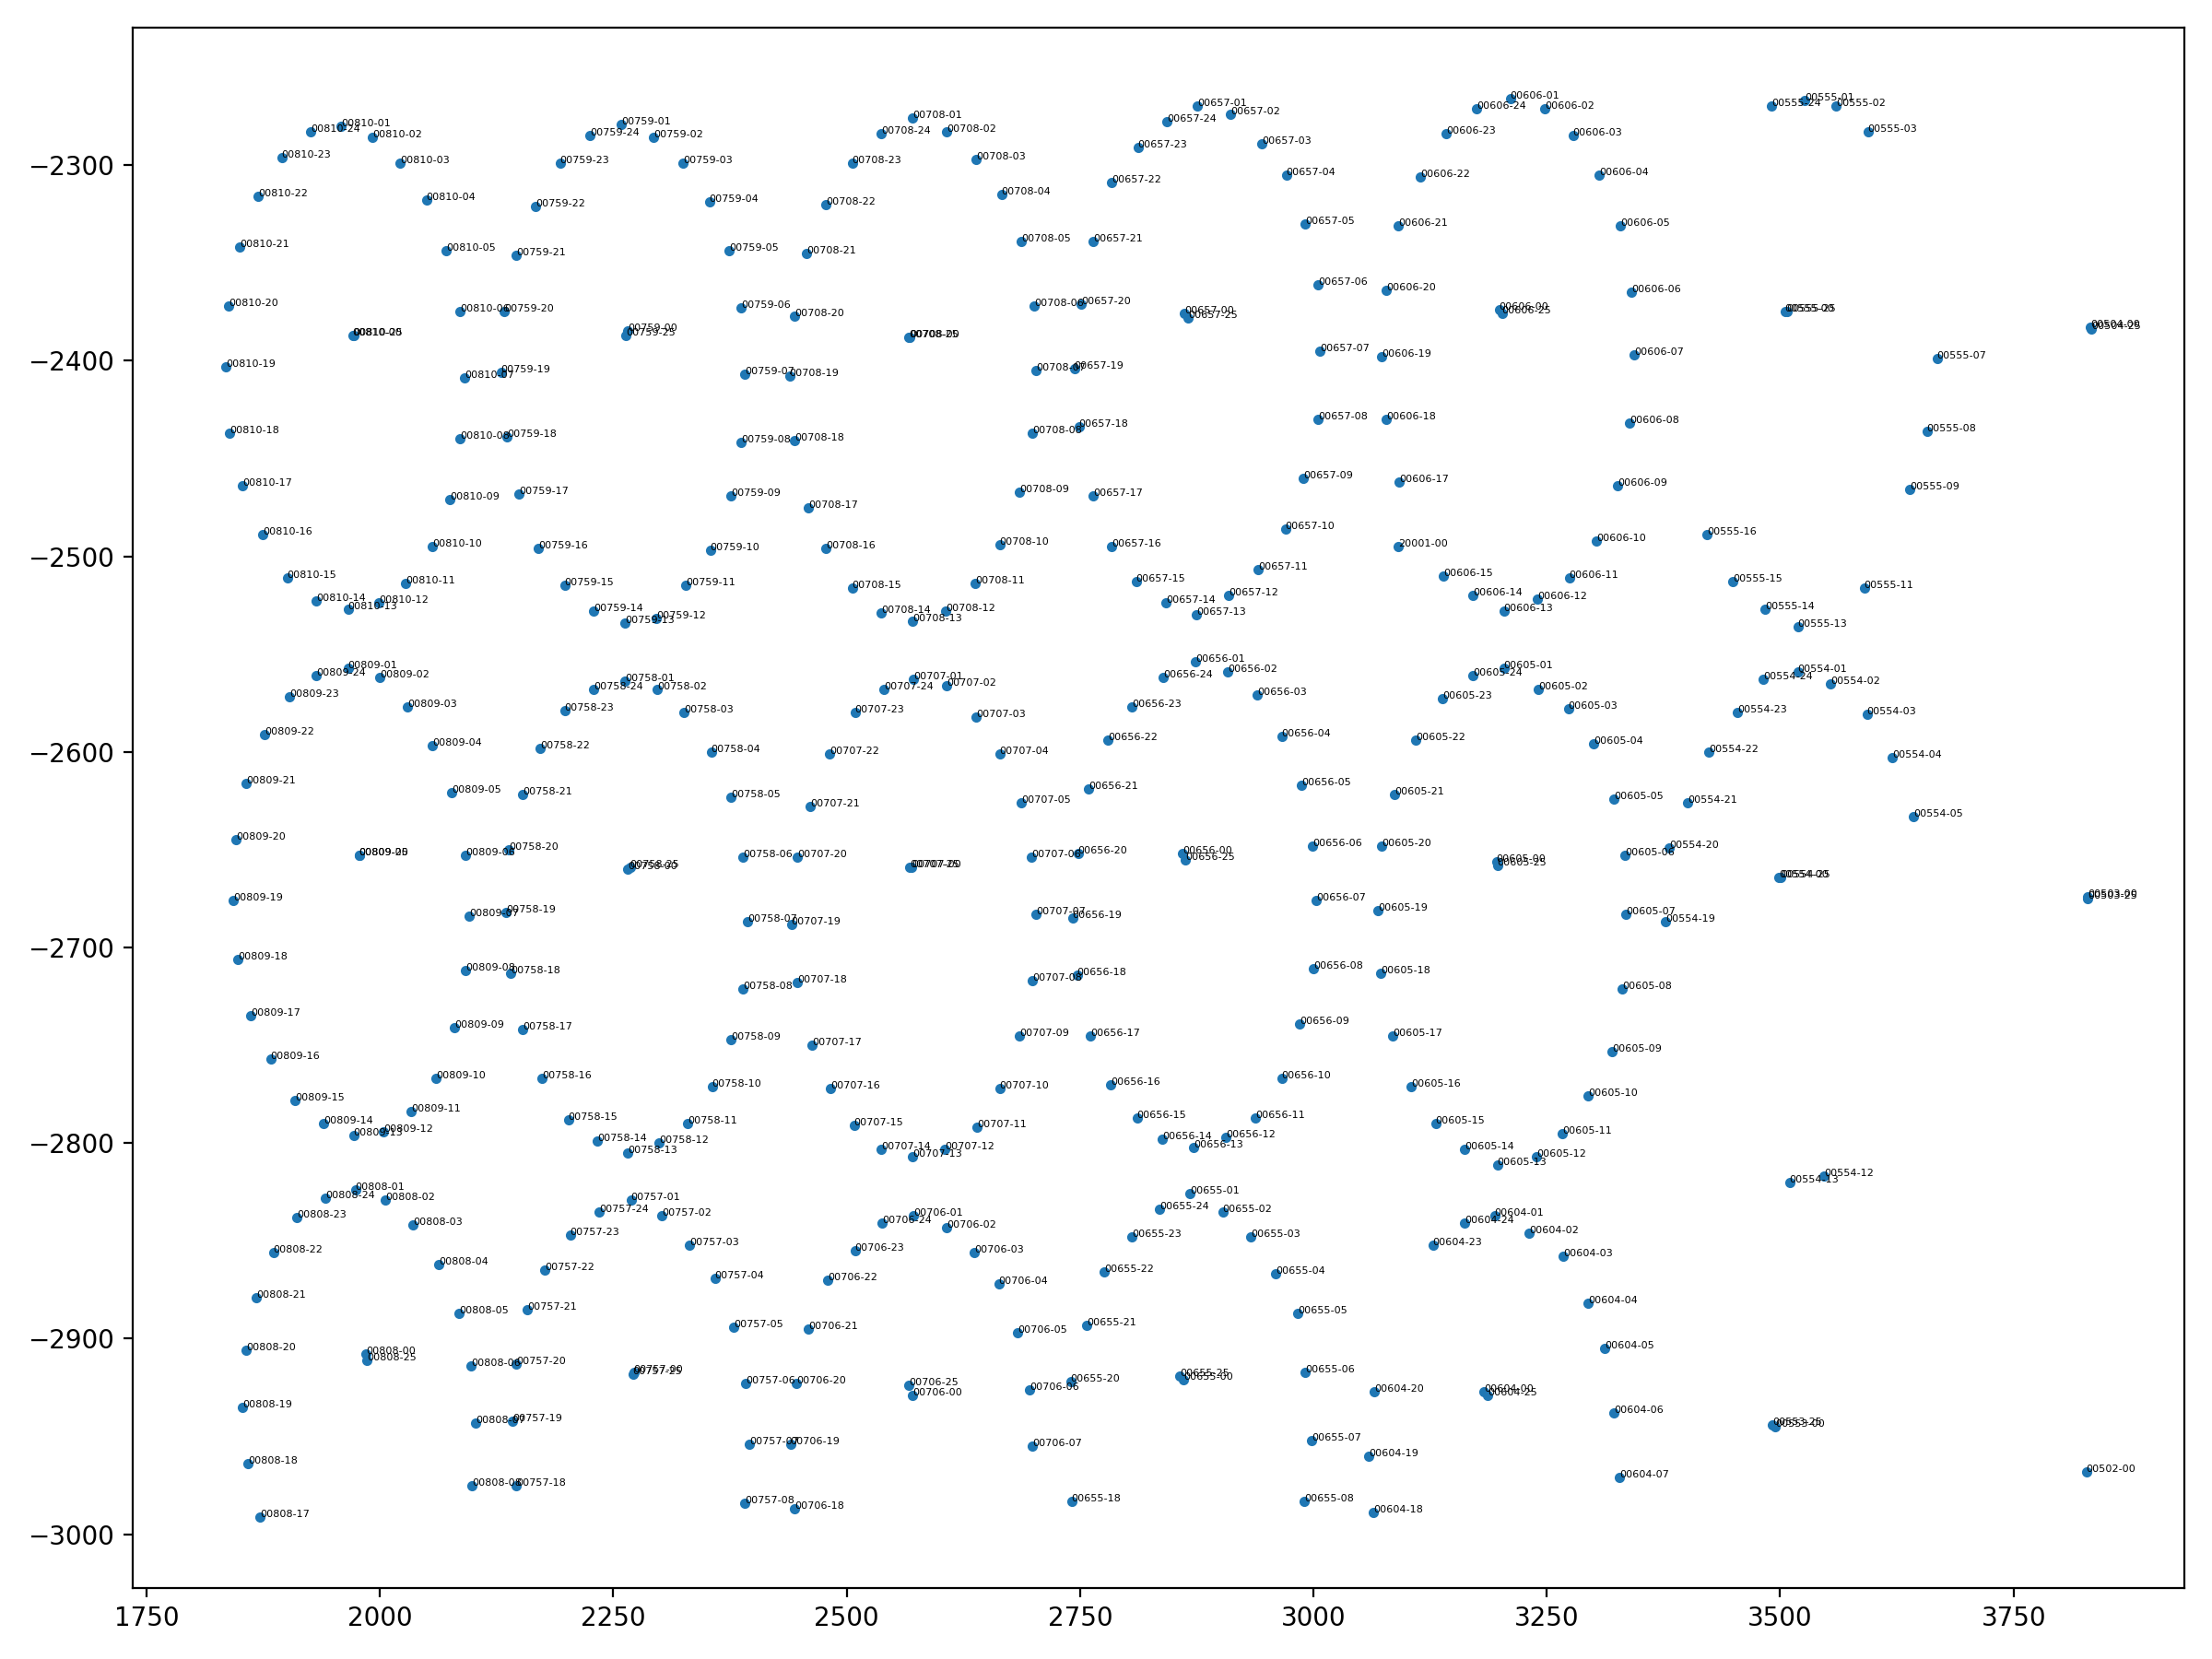

In [73]:
for i in image_feature_locations.values():
    fig, ax = plt.subplots(figsize=(12,9))
    coords = np.stack(list(i.values()))
    ax.scatter(coords[:,0], -coords[:,1], marker='.')
    for t, f in i.items():
        ax.text(f[0], -f[1], t, size=4, zorder=4, color='k')
    fig.tight_layout()
    break

In [74]:
# choose features that appear in 2+ images
feature_counts = Counter([f for i in image_feature_locations.values() for f in i.keys()])
common_features = [f for f in feature_counts if feature_counts[f] > 1]
pmt_locations = {k: p for k, p in all_pmt_locations.items() if k in common_features}
bolt_locations = sk.get_bolt_locations_barrel(pmt_locations)
#all_pmt_locations[common_features[10]]
#for k, i in image_feature_locations.items():
#    image_feature_locations[k] = {j: f for j, f in i.items() if j in common_features}
#pmt_locations = {k: v for k, v in pmt_locations.items() if k in common_features}

In [75]:
common_bolt_locations = {k: f for k, f in bolt_locations.items() if k in common_features}
common_feature_locations = {**pmt_locations, **common_bolt_locations}
common_image_pmt_locations = {
    k: {j: f for j, f in i.items() if j in common_features and j in pmt_locations}
    for k, i in image_feature_locations.items()}
common_image_feature_locations = {
    k: {j: f for j, f in i.items() if j in common_features and j in common_feature_locations}
    for k, i in image_feature_locations.items()}
common_image_bolt_locations = {
    k: {j: f for j, f in i.items() if j in common_features and j in common_bolt_locations}
    for k, i in image_feature_locations.items()}
nimages = len(common_image_feature_locations)
nfeatures = len(common_feature_locations)
print(nimages, nfeatures)

14 599


<IPython.core.display.Javascript object>


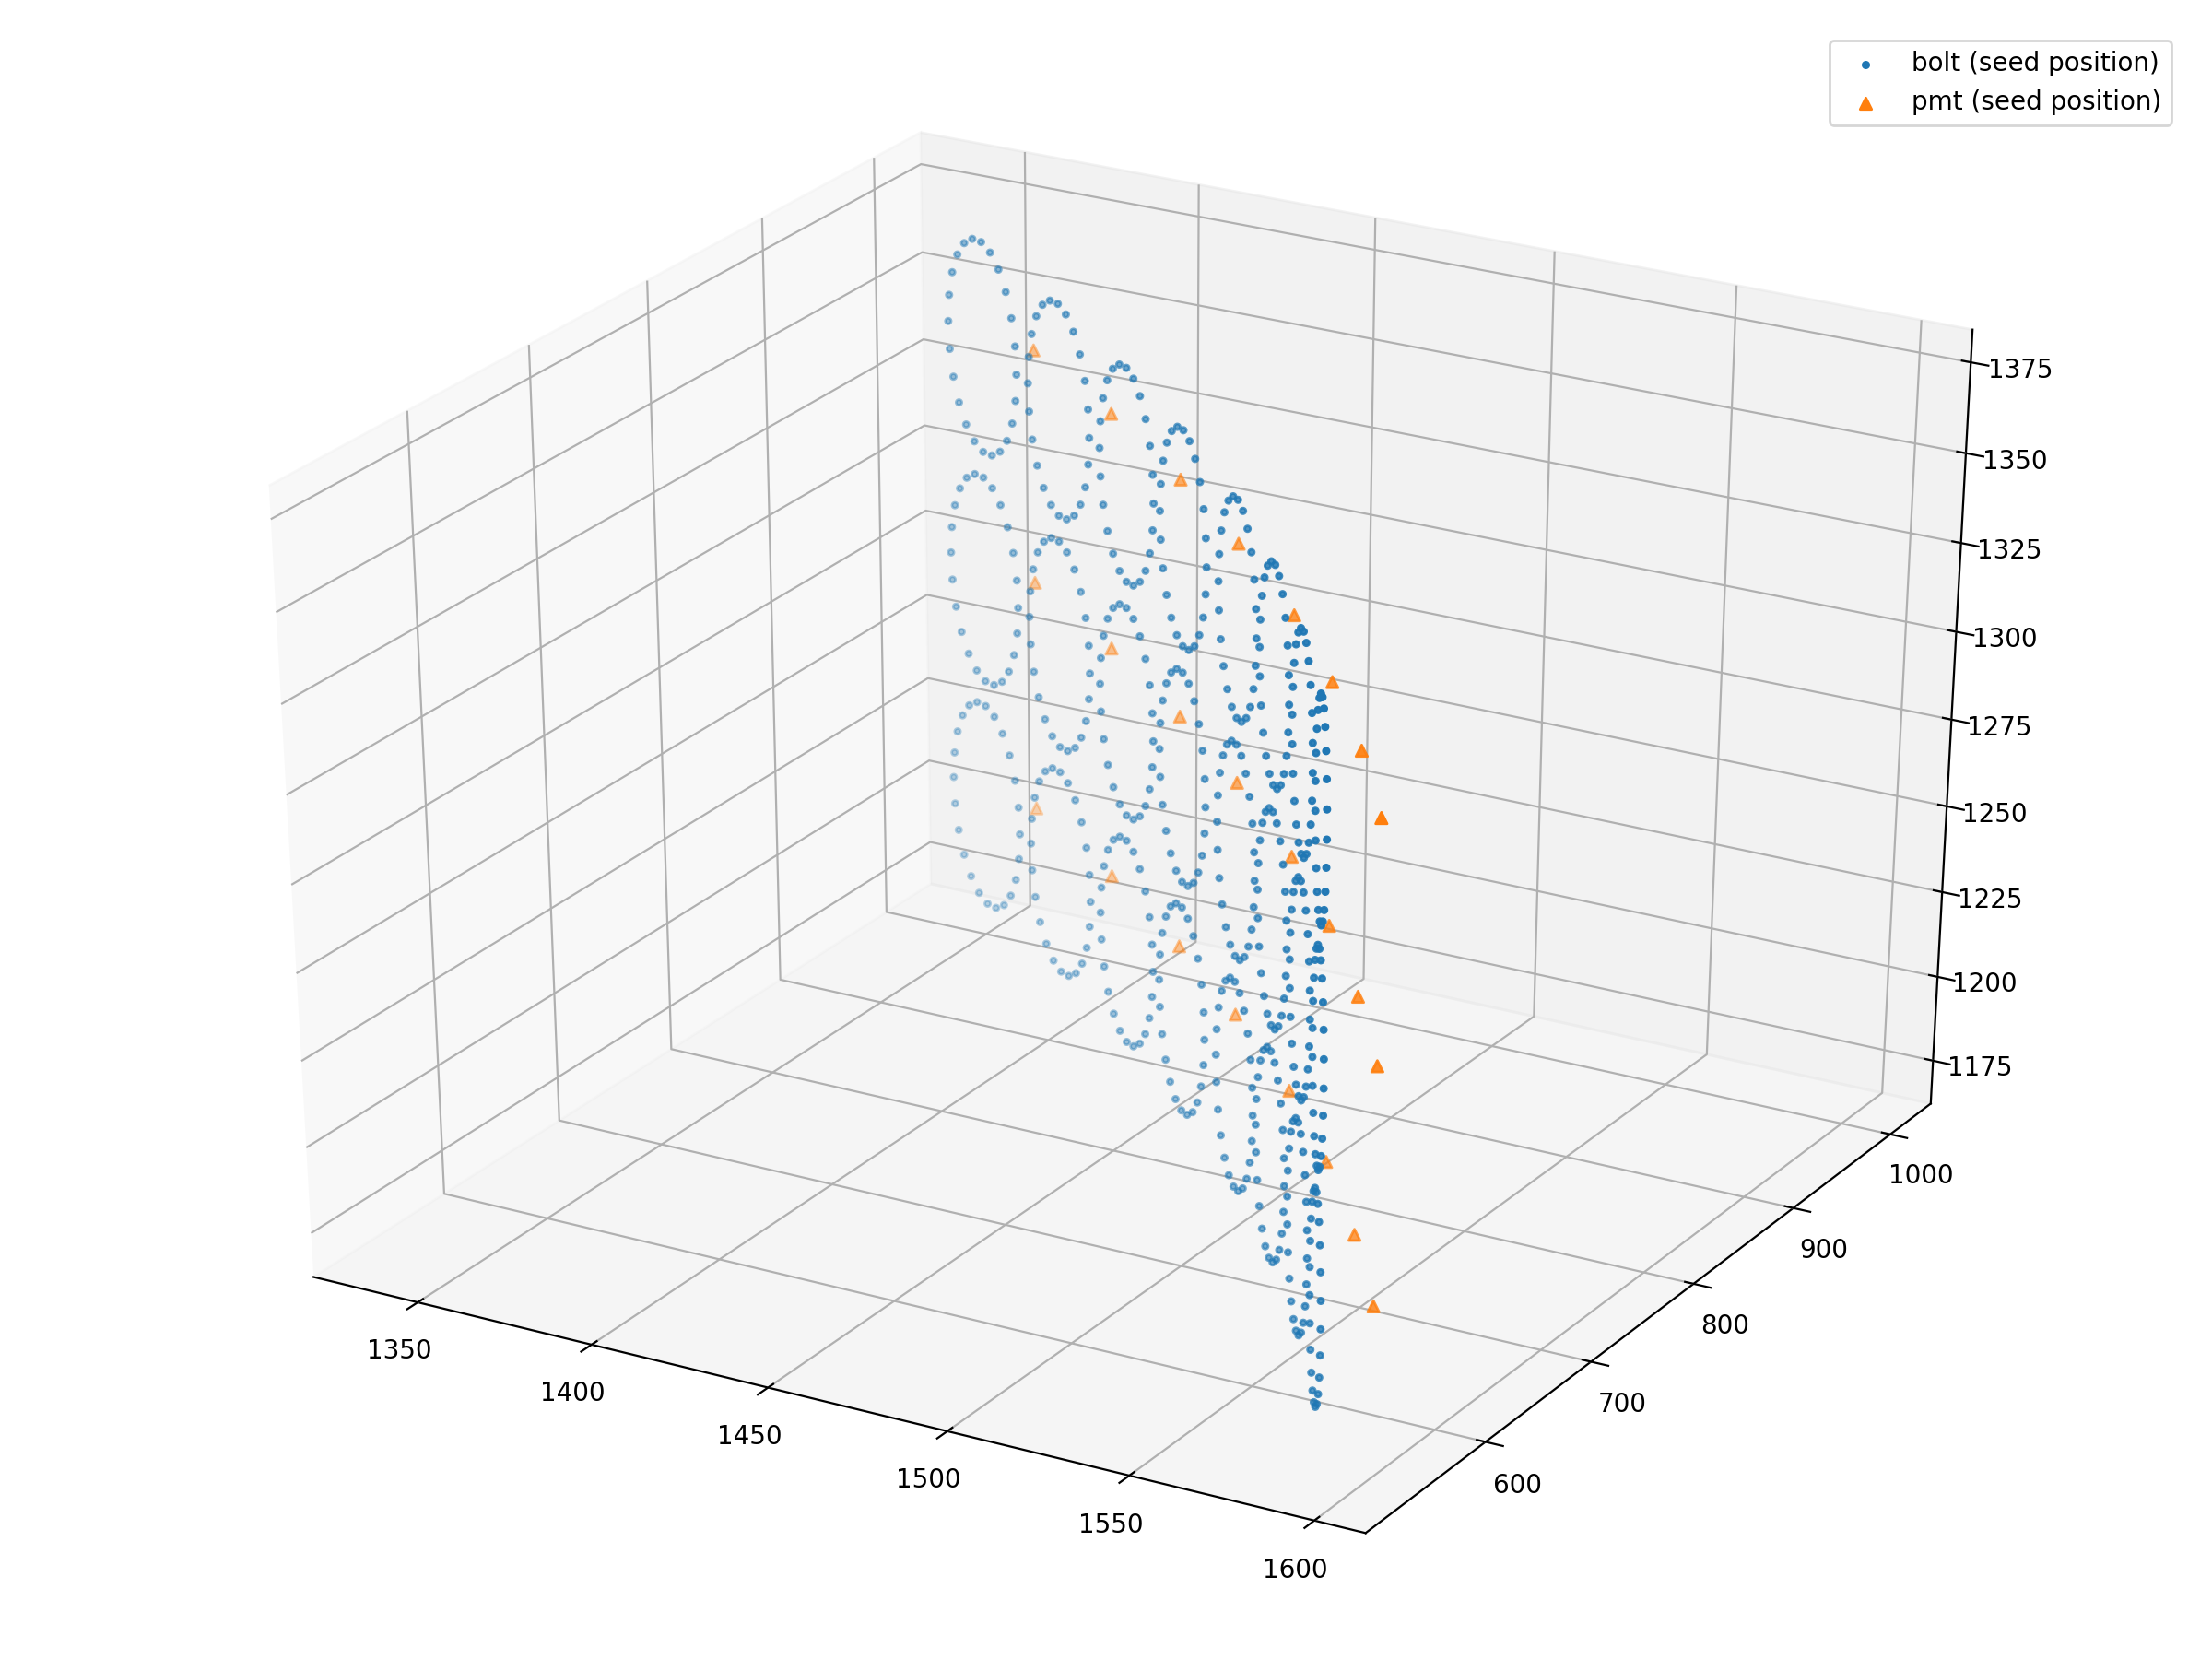

In [76]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='3d')
bolt_array = np.stack(list(bolt_locations.values()))
pmt_array = np.stack(list(pmt_locations.values()))
ax.scatter(bolt_array[:,0], bolt_array[:,1], bolt_array[:,2], marker='.', label="bolt (seed position)")
ax.scatter(pmt_array[:,0], pmt_array[:,1], pmt_array[:,2], marker='^', label="pmt (seed position)")
plt.legend(loc=0)
fig.tight_layout()

<IPython.core.display.Javascript object>


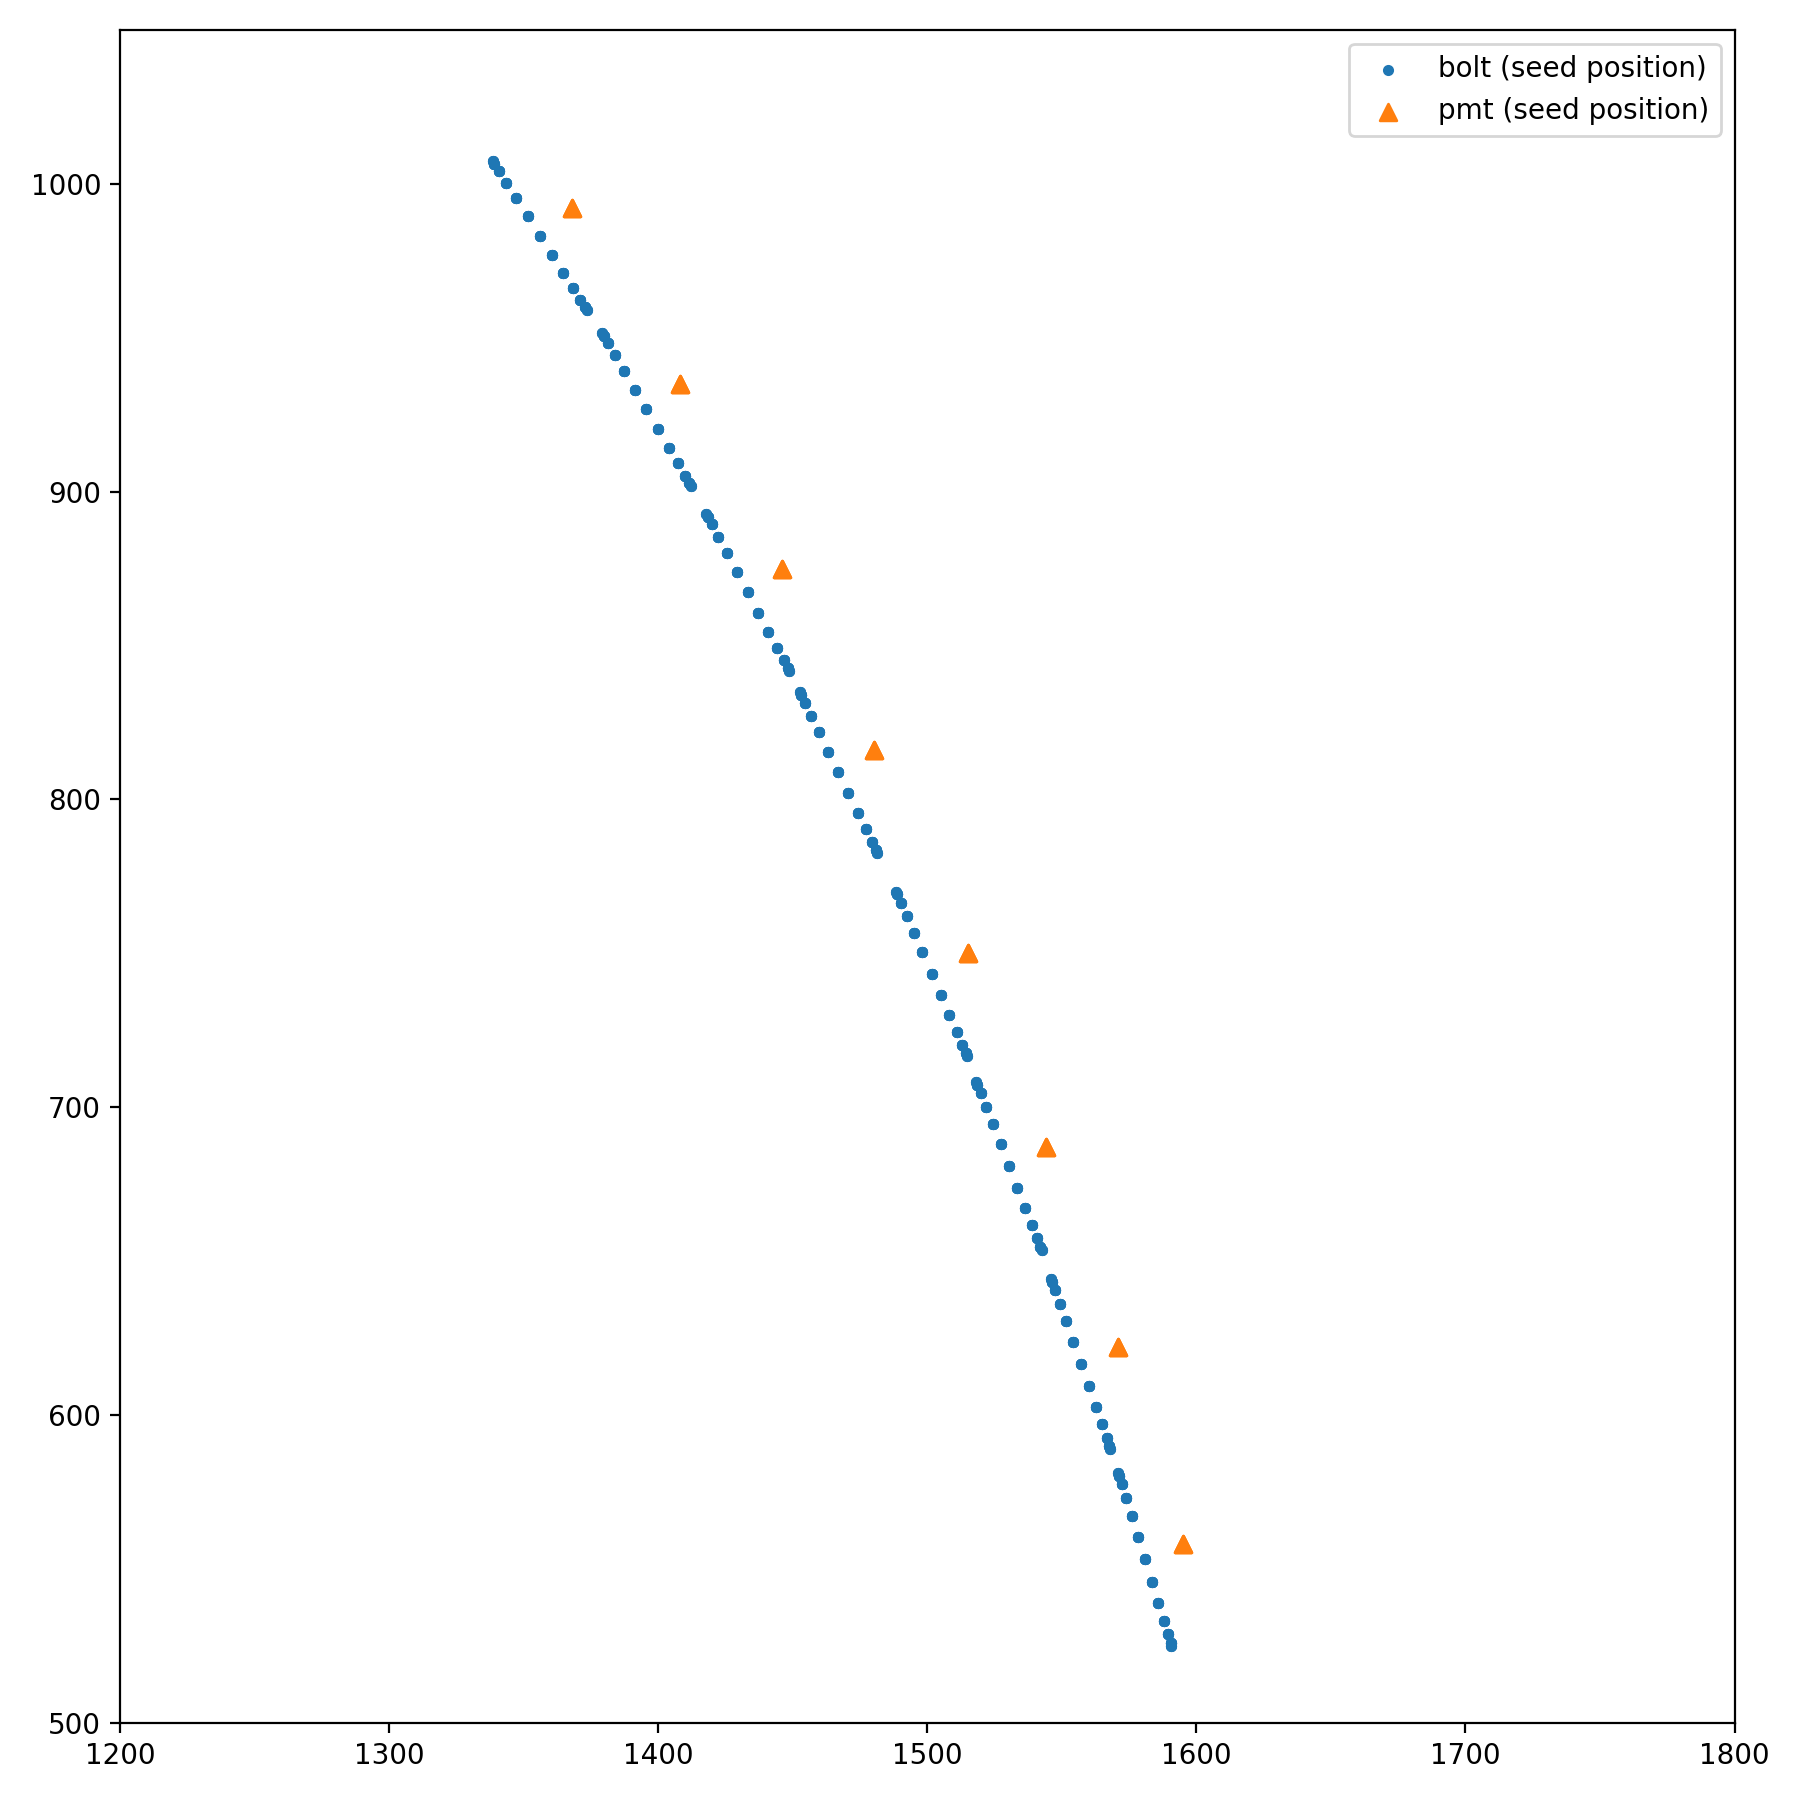

In [77]:
fig, ax = plt.subplots(figsize=(9,9))
bolt_array = np.stack(list(bolt_locations.values()))
pmt_array = np.stack(list(pmt_locations.values()))
ax.scatter(bolt_array[:,0], bolt_array[:,1], marker='.', label="bolt (seed position)")
ax.scatter(pmt_array[:,0], pmt_array[:,1], marker='^', label="pmt (seed position)")
ax.set_ylim((500,1050))
ax.set_xlim((1200,1800))
plt.legend(loc=0)
fig.tight_layout()

In [78]:
fitter_pmts = fit.PhotogrammetryFitter(common_image_pmt_locations, pmt_locations,
                                       focal_length, principle_point, radial_distortion)
fitter_bolts = fit.PhotogrammetryFitter(common_image_bolt_locations, common_bolt_locations,
                                       focal_length, principle_point, radial_distortion)
fitter_all = fit.PhotogrammetryFitter(common_image_feature_locations, common_feature_locations,
                                       focal_length, principle_point, radial_distortion)

In [79]:
camera_rotations, camera_translations, reprojected_points = fitter_all.estimate_camera_poses(flags=cv2.SOLVEPNP_EPNP)

image 0 reprojection errors:    average: 30.586658537480922    max: 44.526957468433565
image 1 reprojection errors:    average: 32.689610795177465    max: 59.34016857257772
image 2 reprojection errors:    average: 31.54288503599044    max: 45.72103654056668
image 3 reprojection errors:    average: 31.194932905664395    max: 82.95240311243427
image 4 reprojection errors:    average: 25.229241269297734    max: 50.38556141712111
image 5 reprojection errors:    average: 23.68087035711376    max: 39.973641485004954
image 6 reprojection errors:    average: 20.32171374135468    max: 32.533631861355026
image 7 reprojection errors:    average: 19.56361124366998    max: 33.22310653641808
image 8 reprojection errors:    average: 17.658238434065066    max: 34.855583920053846
image 9 reprojection errors:    average: 25.35092638403429    max: 41.49945697860997
image 10 reprojection errors:    average: 26.985766916078063    max: 50.12835782855803
image 11 reprojection errors:    average: 34.970752516

<IPython.core.display.Javascript object>


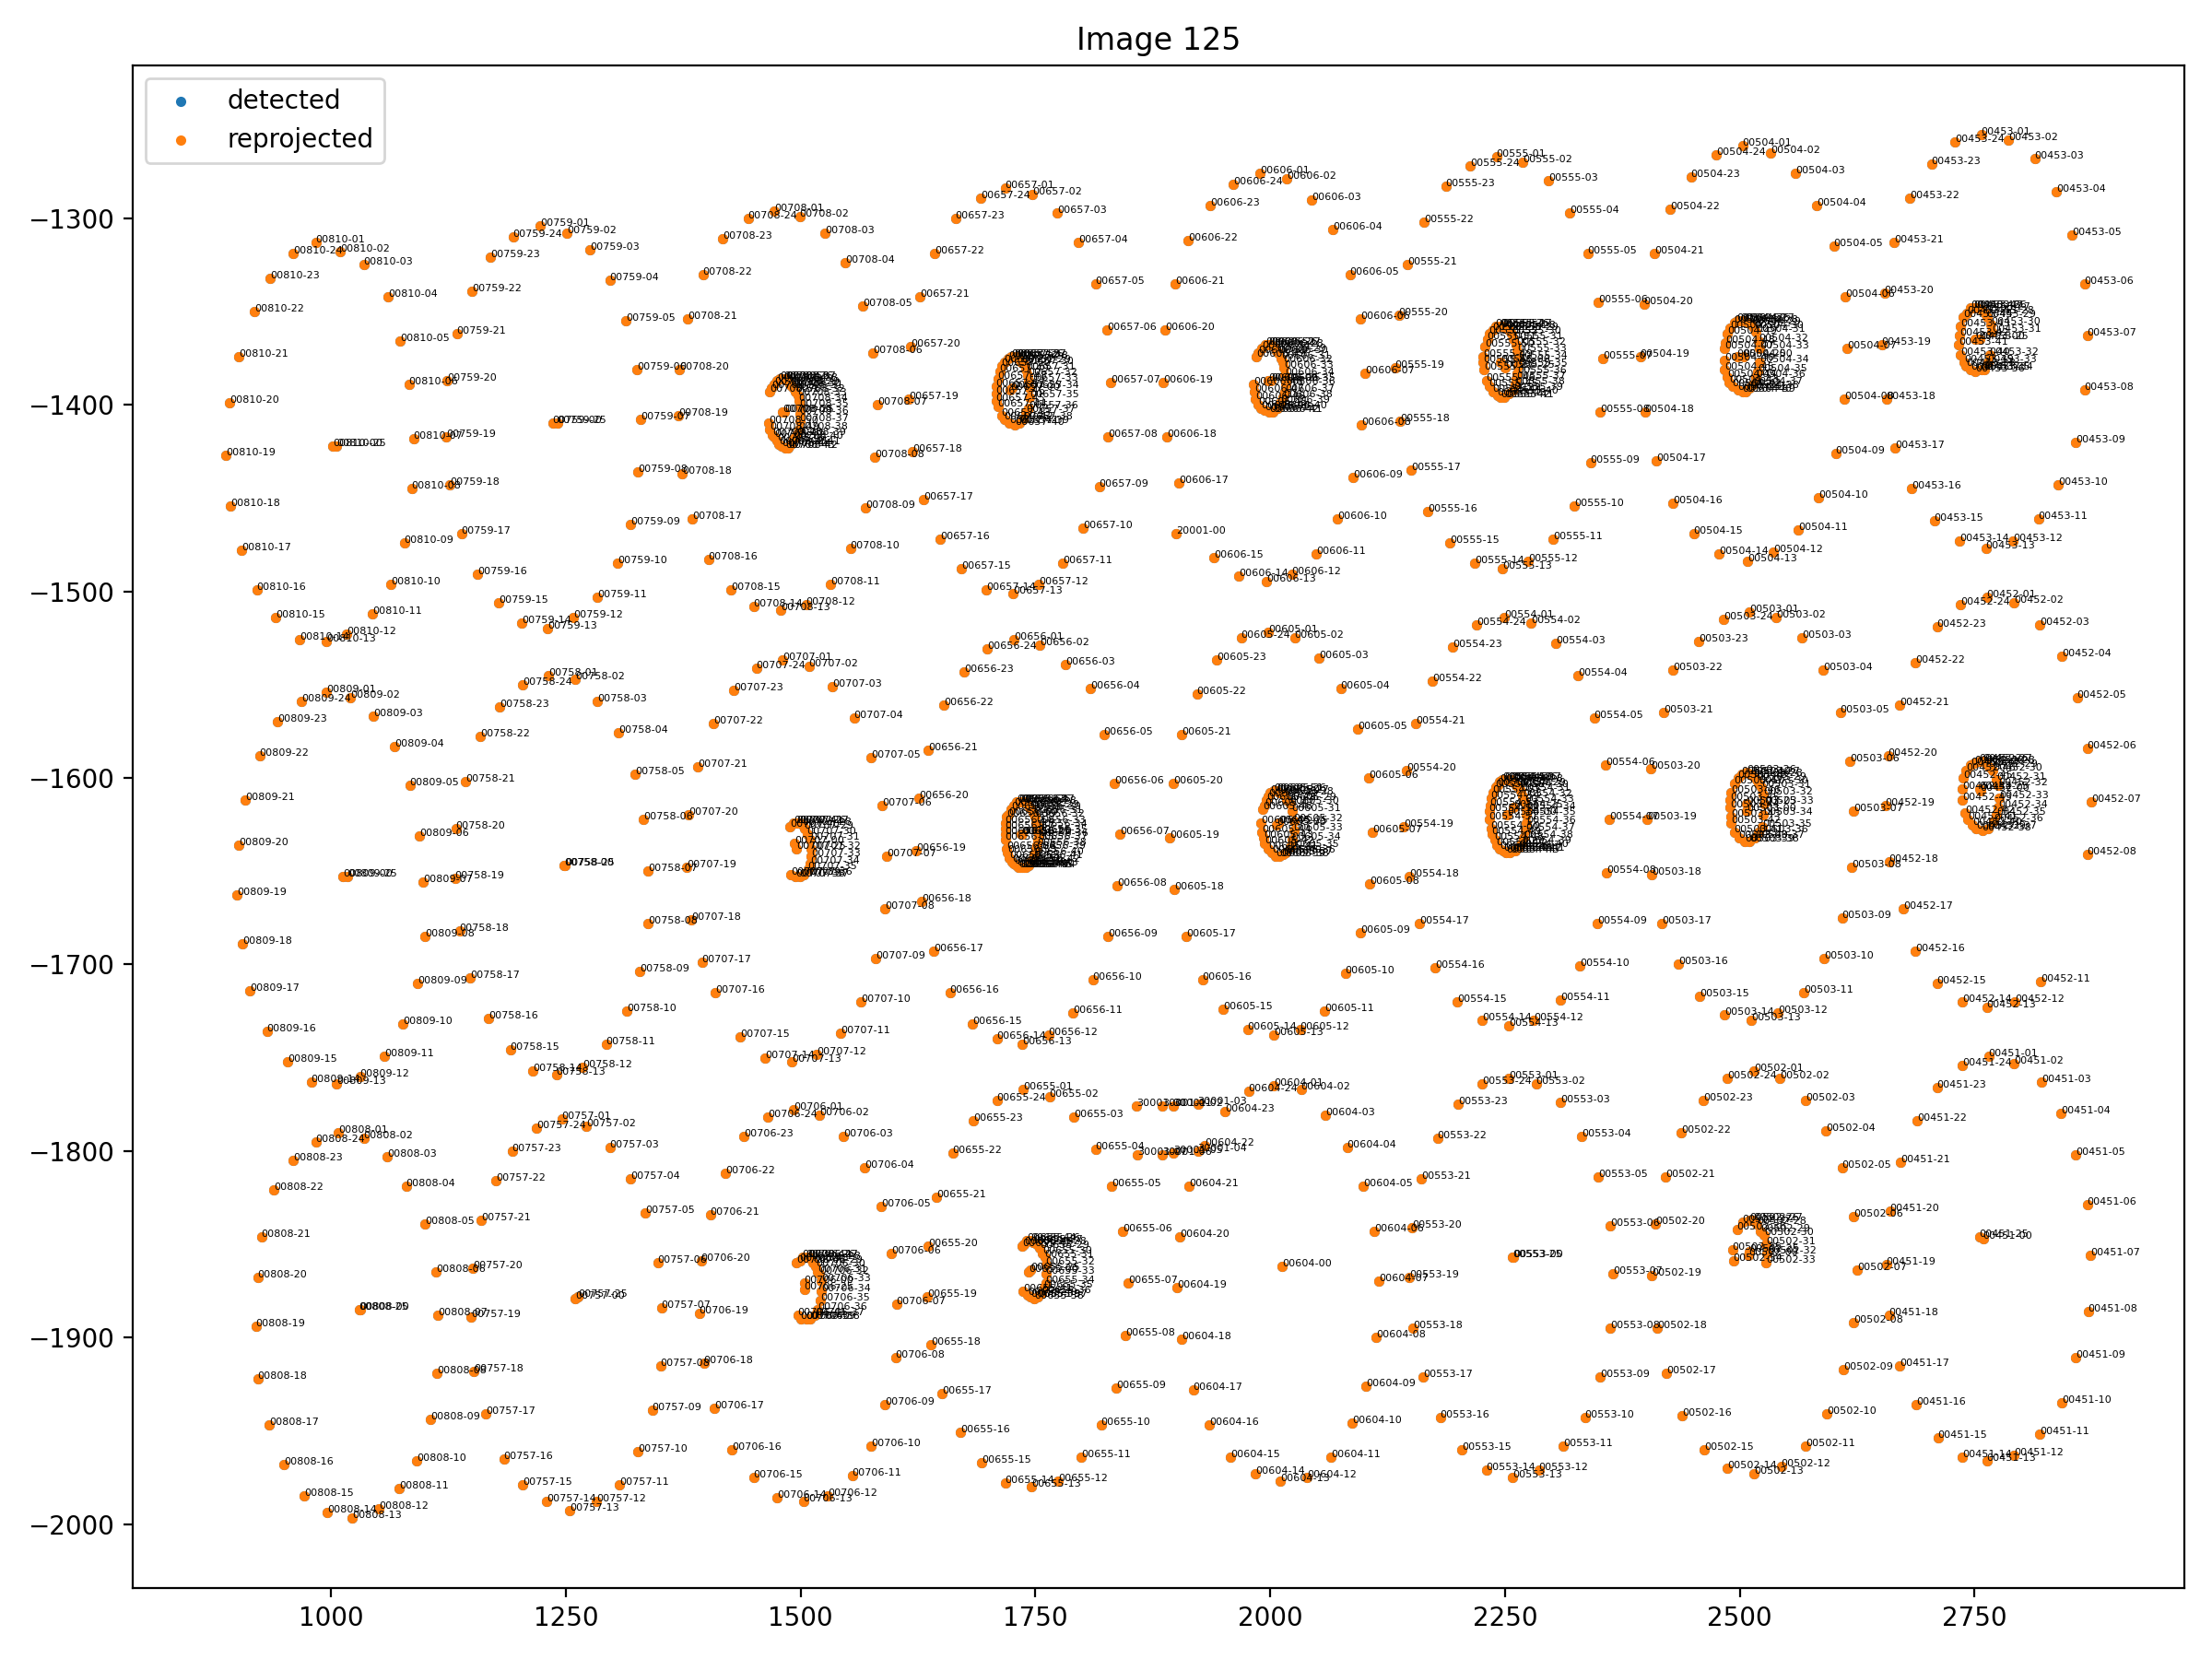

In [80]:
test_image = image_feature_locations[fitter_pmts.index_image[11]]
fig, ax = plt.subplots(figsize=(12,9))
coords = np.stack(list(test_image.values()))
repro_coords = np.stack(list(test_image.values()))
ax.scatter(coords[:,0], -coords[:,1], marker='.', label='detected')
ax.scatter(repro_coords[:,0], -repro_coords[:,1], marker='.', label='reprojected')
for t, f in test_image.items():
    ax.text(f[0], -f[1], t, size=4, zorder=4, color='k')
ax.set_title("Image {}".format(fitter_pmts.index_image[6]))
plt.legend(loc=0)
fig.tight_layout()

<IPython.core.display.Javascript object>


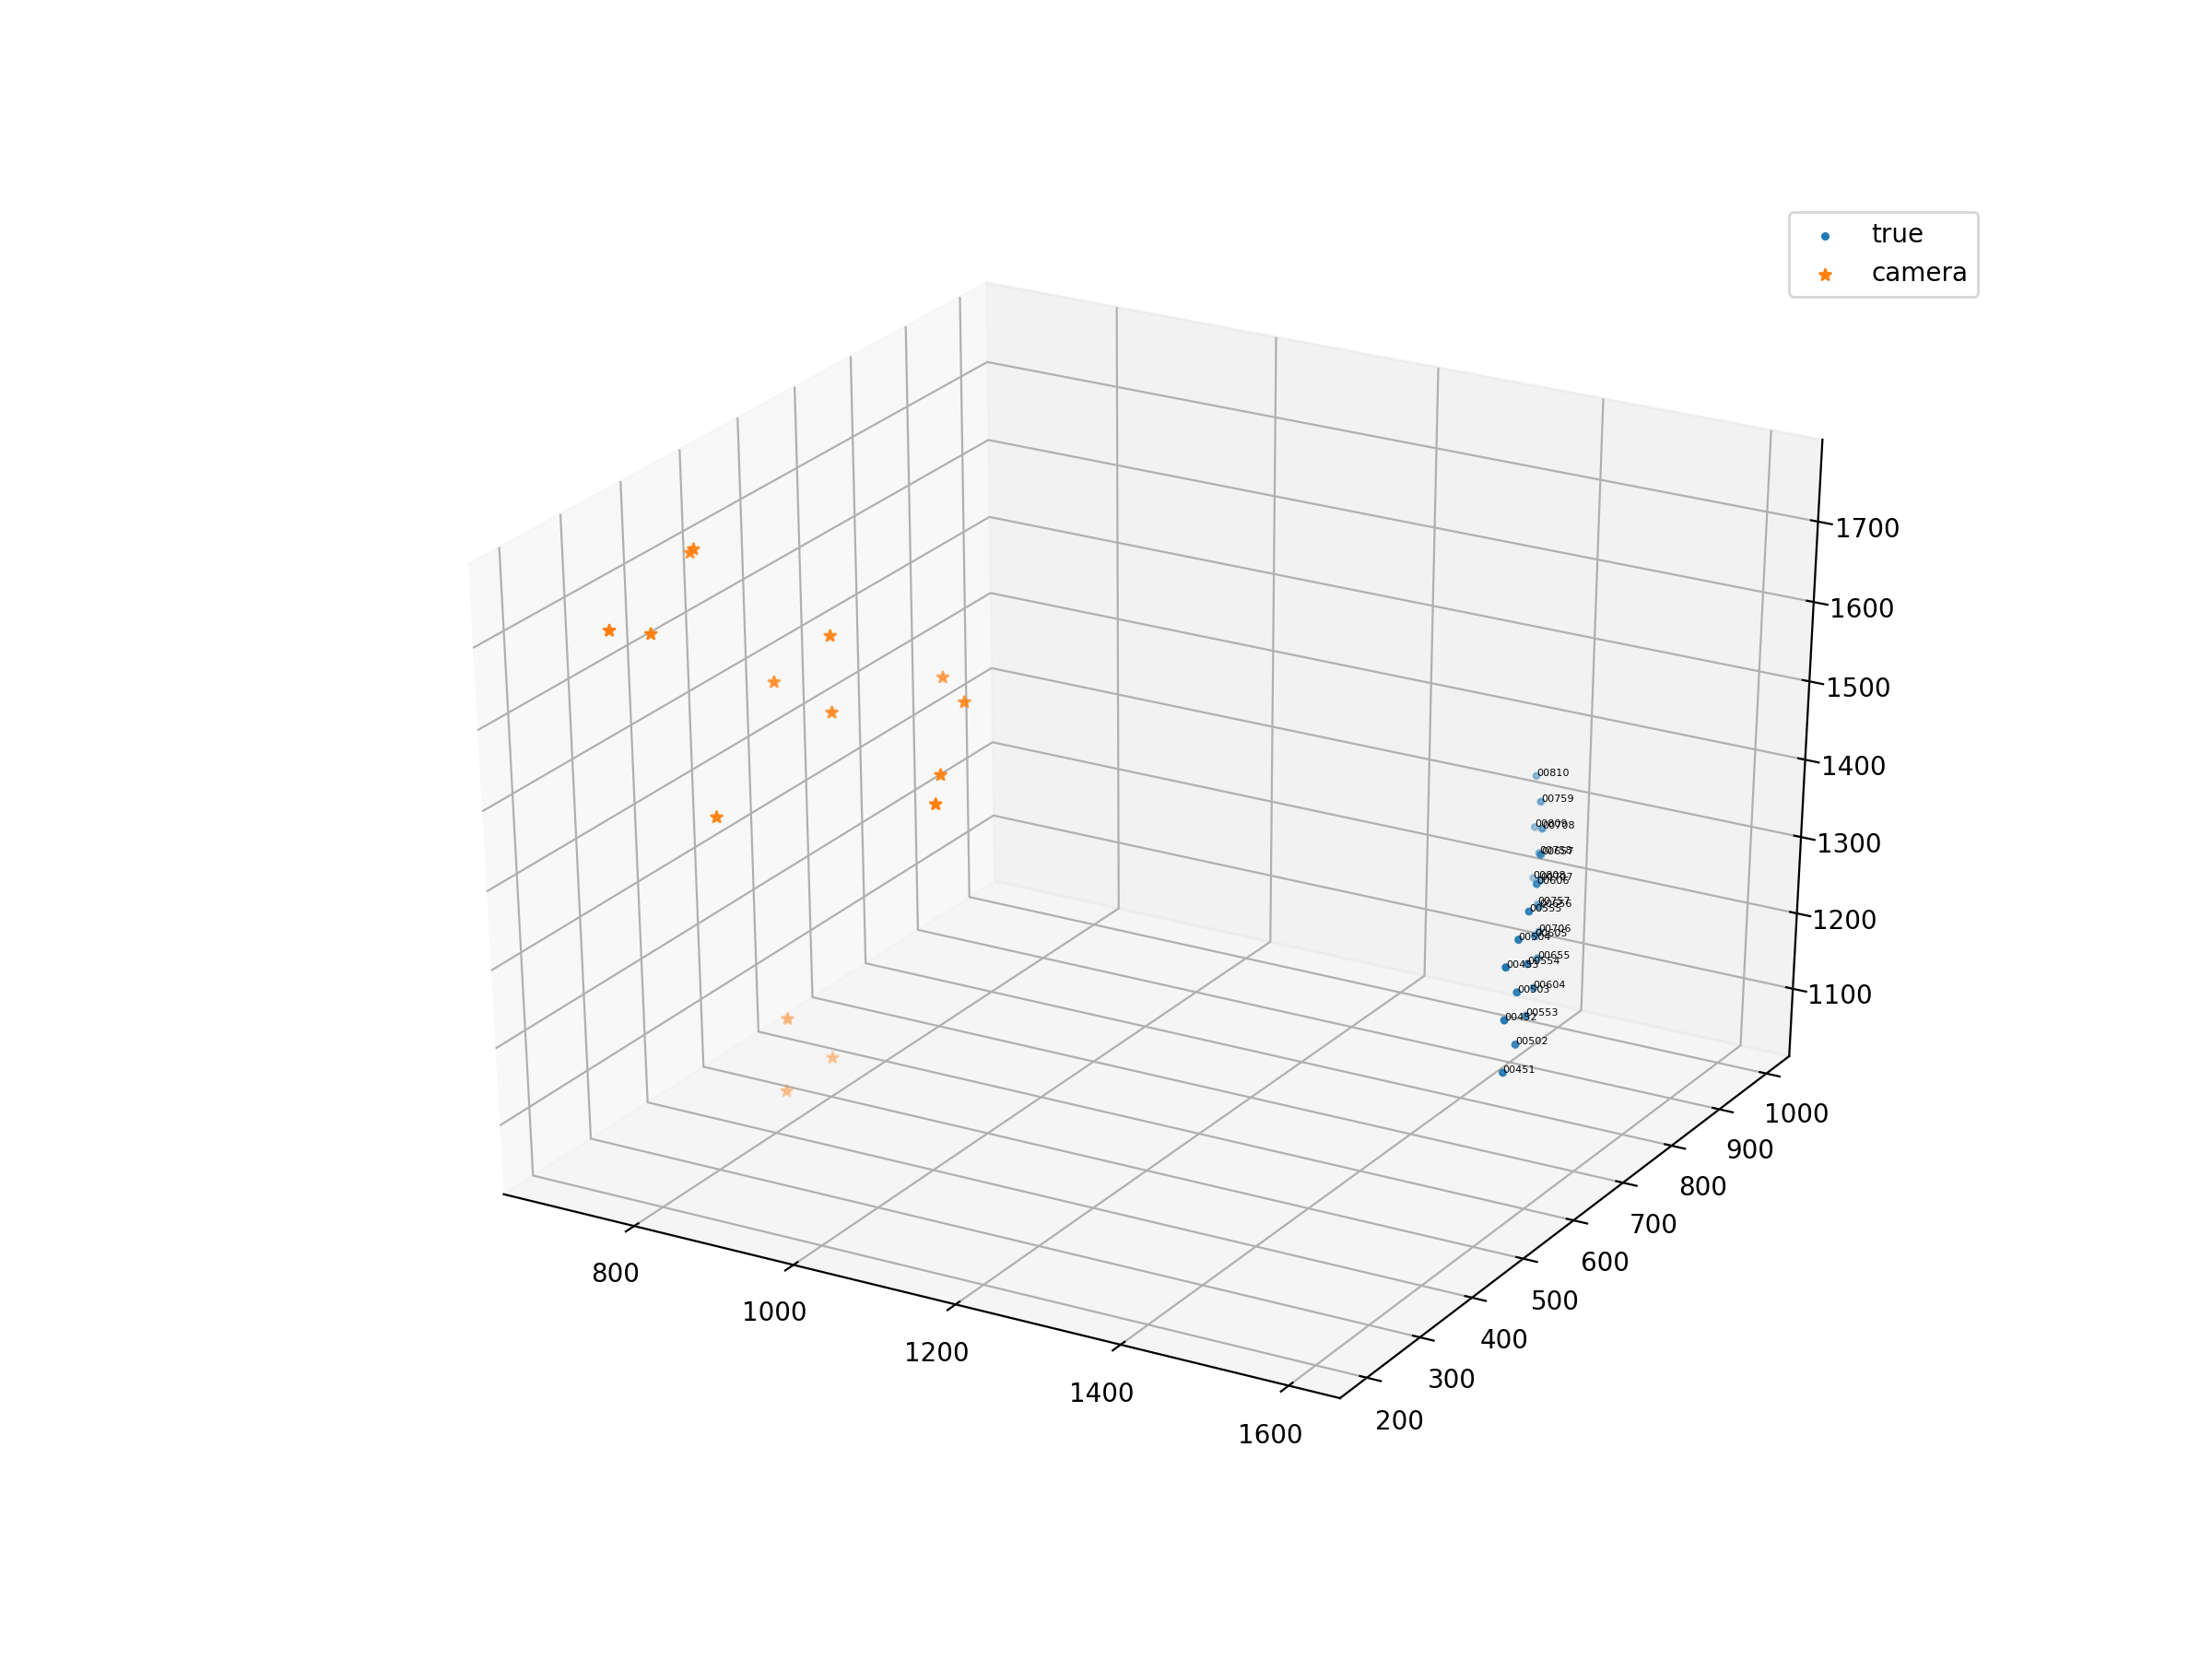

In [65]:
camera_orientations, camera_positions = fit.camera_world_poses(camera_rotations, camera_translations)
fig = plt.figure(figsize=(12,9))
pmt_array = np.stack(list(pmt_locations.values()))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pmt_array[:,0], pmt_array[:,1], pmt_array[:,2], marker='.', label="true", zorder=2)
for i, f in enumerate(pmt_locations.keys()):
    ax.text(pmt_array[i,0], pmt_array[i,1], pmt_array[i,2], f[:5], size=4, zorder=4, color='k') 
ax.scatter(camera_positions[:,0], camera_positions[:,1], camera_positions[:,2], marker='*', label="camera", zorder=1)
plt.legend(loc=0)

In [39]:
camera_rotations, camera_translations, reco_locations = fitter_all.bundle_adjustment(camera_rotations, camera_translations)

`ftol` termination condition is satisfied.
Function evaluations 11337, initial cost 2.6804e+06, final cost 4.6911e+04, first-order optimality 1.01e+02.
mean reprojection error: 1.9512094687608688
max reprojection error: 189.31662241022516


In [40]:
errors, reco_transformed, scale, R, translation, location_mean = fit.kabsch_errors(
    common_feature_locations, reco_locations)
print("mean reconstruction error:", linalg.norm(errors, axis=1).mean())
print("max reconstruction error:", linalg.norm(errors, axis=1).max())

mean reconstruction error: 7.634165082677742
max reconstruction error: 16.47593215265055


In [41]:
camera_orientations, camera_positions = fit.camera_world_poses(camera_rotations, camera_translations)
camera_orientations = np.matmul(R, camera_orientations)
camera_positions = camera_positions - translation
camera_positions = scale*R.dot(camera_positions.transpose()).transpose() + location_mean

<IPython.core.display.Javascript object>


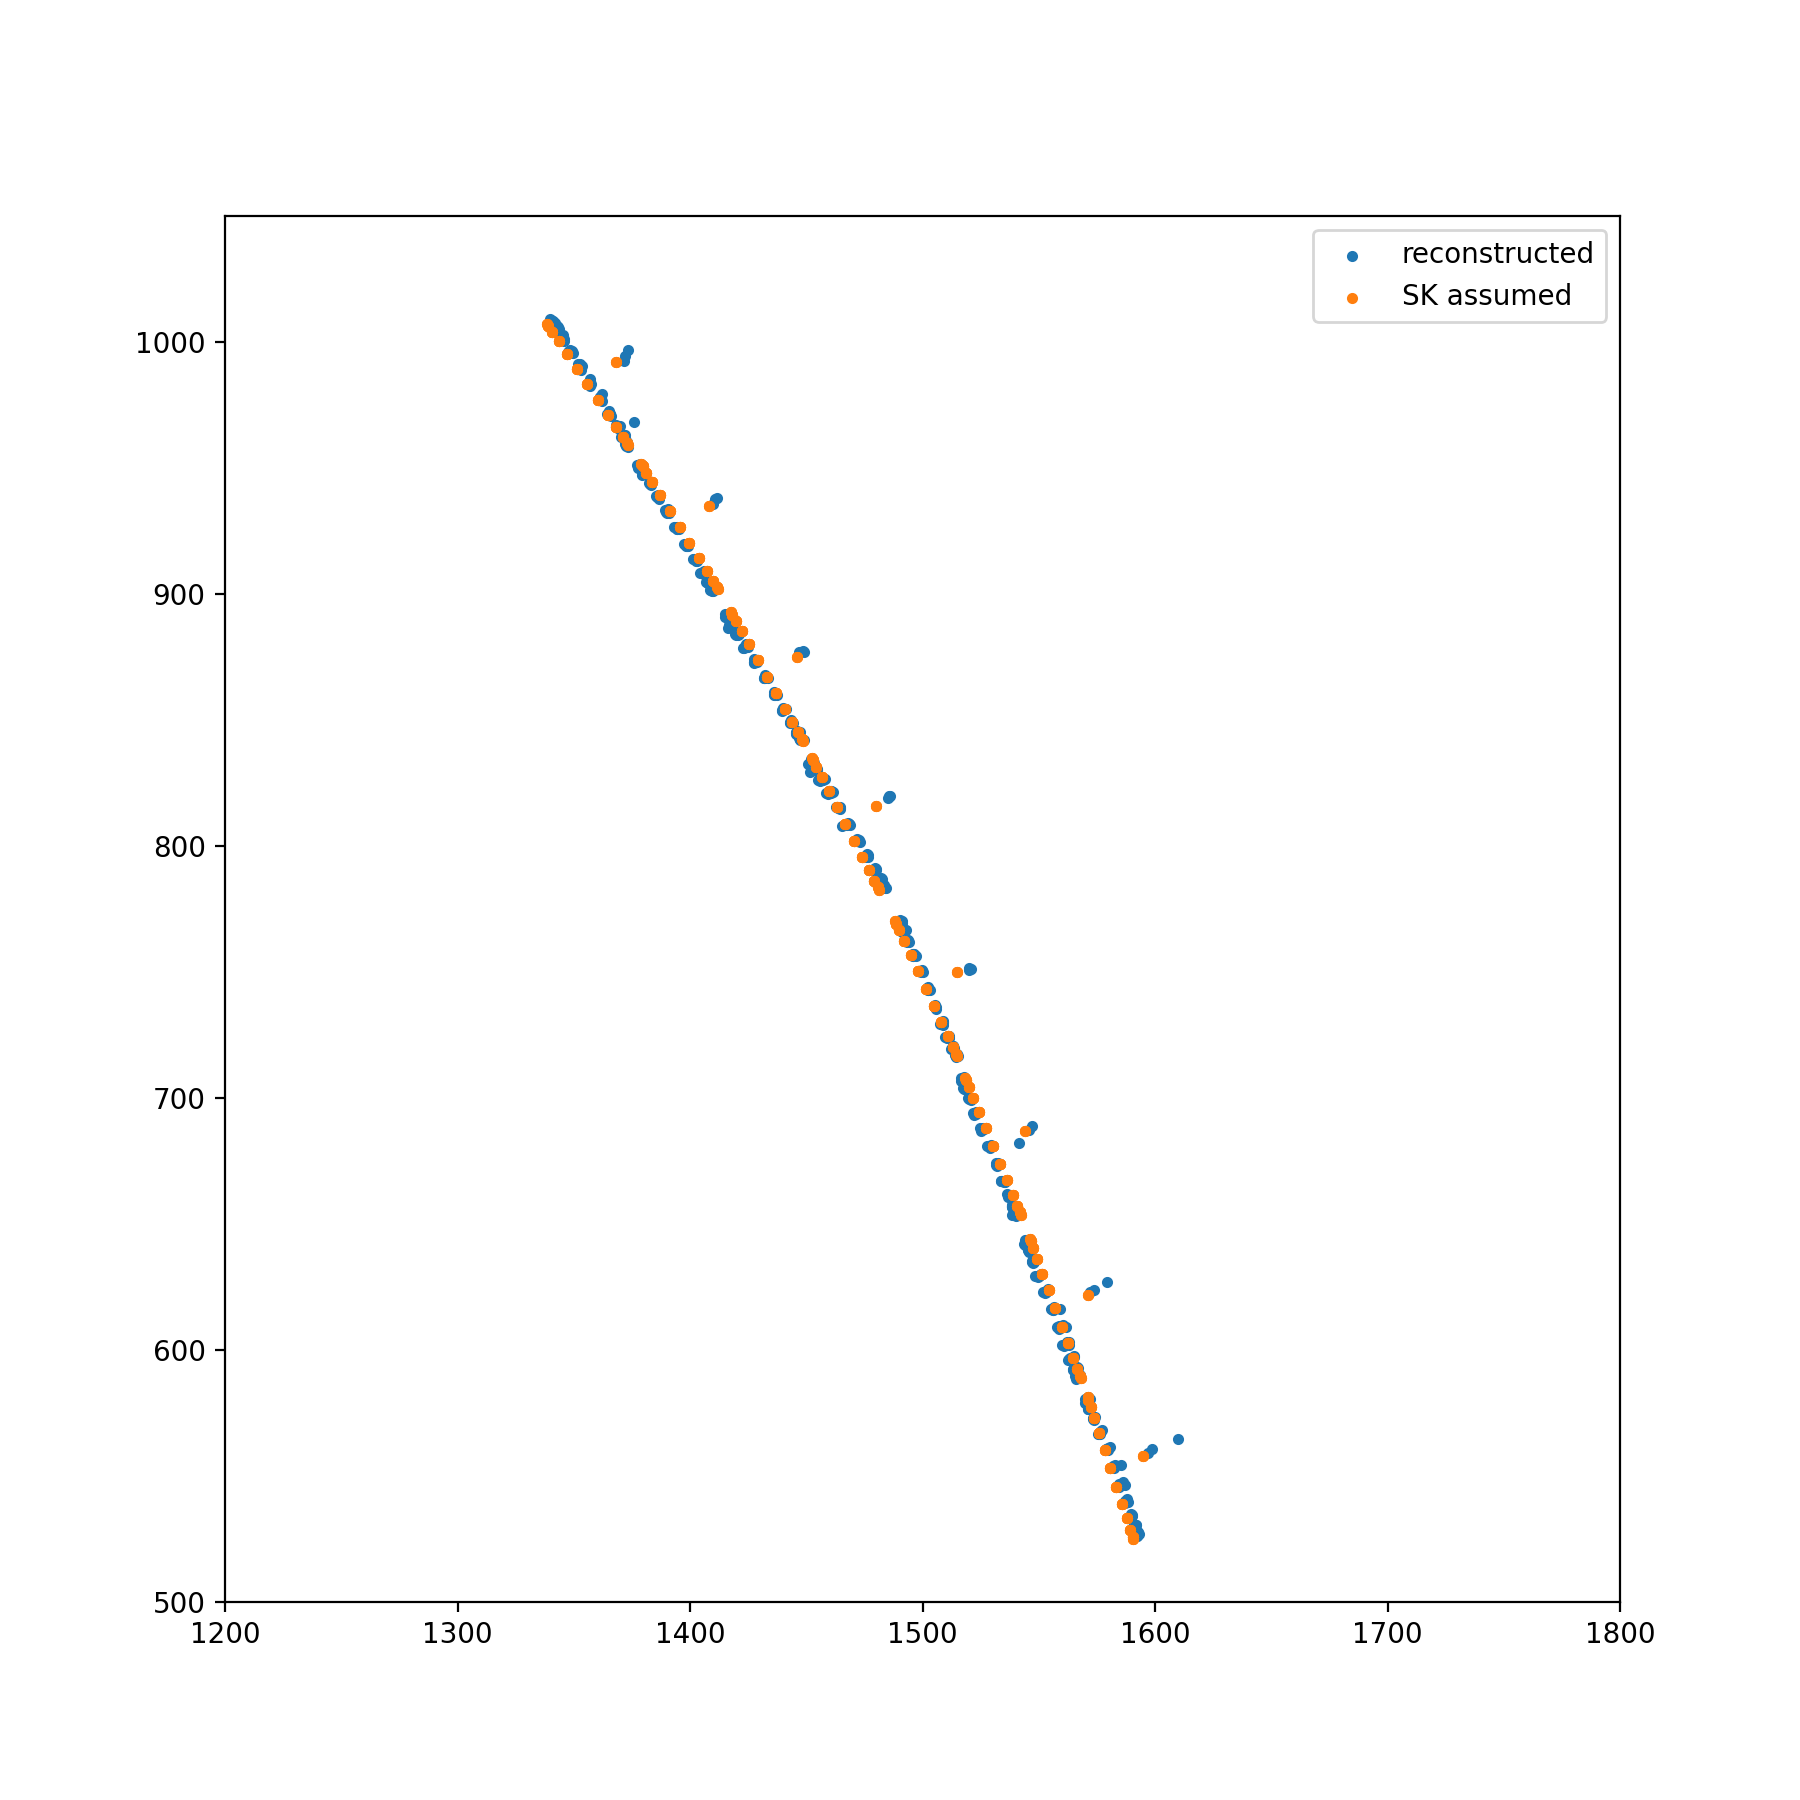

In [57]:
true_array = np.stack(list(common_feature_locations.values()))
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111)
ax.scatter(reco_transformed[:,0], reco_transformed[:,1], marker='.', label="reconstructed")
ax.scatter(true_array[:,0], true_array[:,1], marker='.', label="SK assumed")
ax.set_ylim((500,1050))
ax.set_xlim((1200,1800))
#for i, f in enumerate(pmt_locations.keys()):
#    ax.text(reco_transformed[i,0], reco_transformed[i,1], f, size=4, zorder=1, color='k') 
#ax.scatter(camera_positions[:,0], camera_positions[:,1], camera_positions[:,2], marker='*', label="camera")
plt.legend(loc=0)

<IPython.core.display.Javascript object>


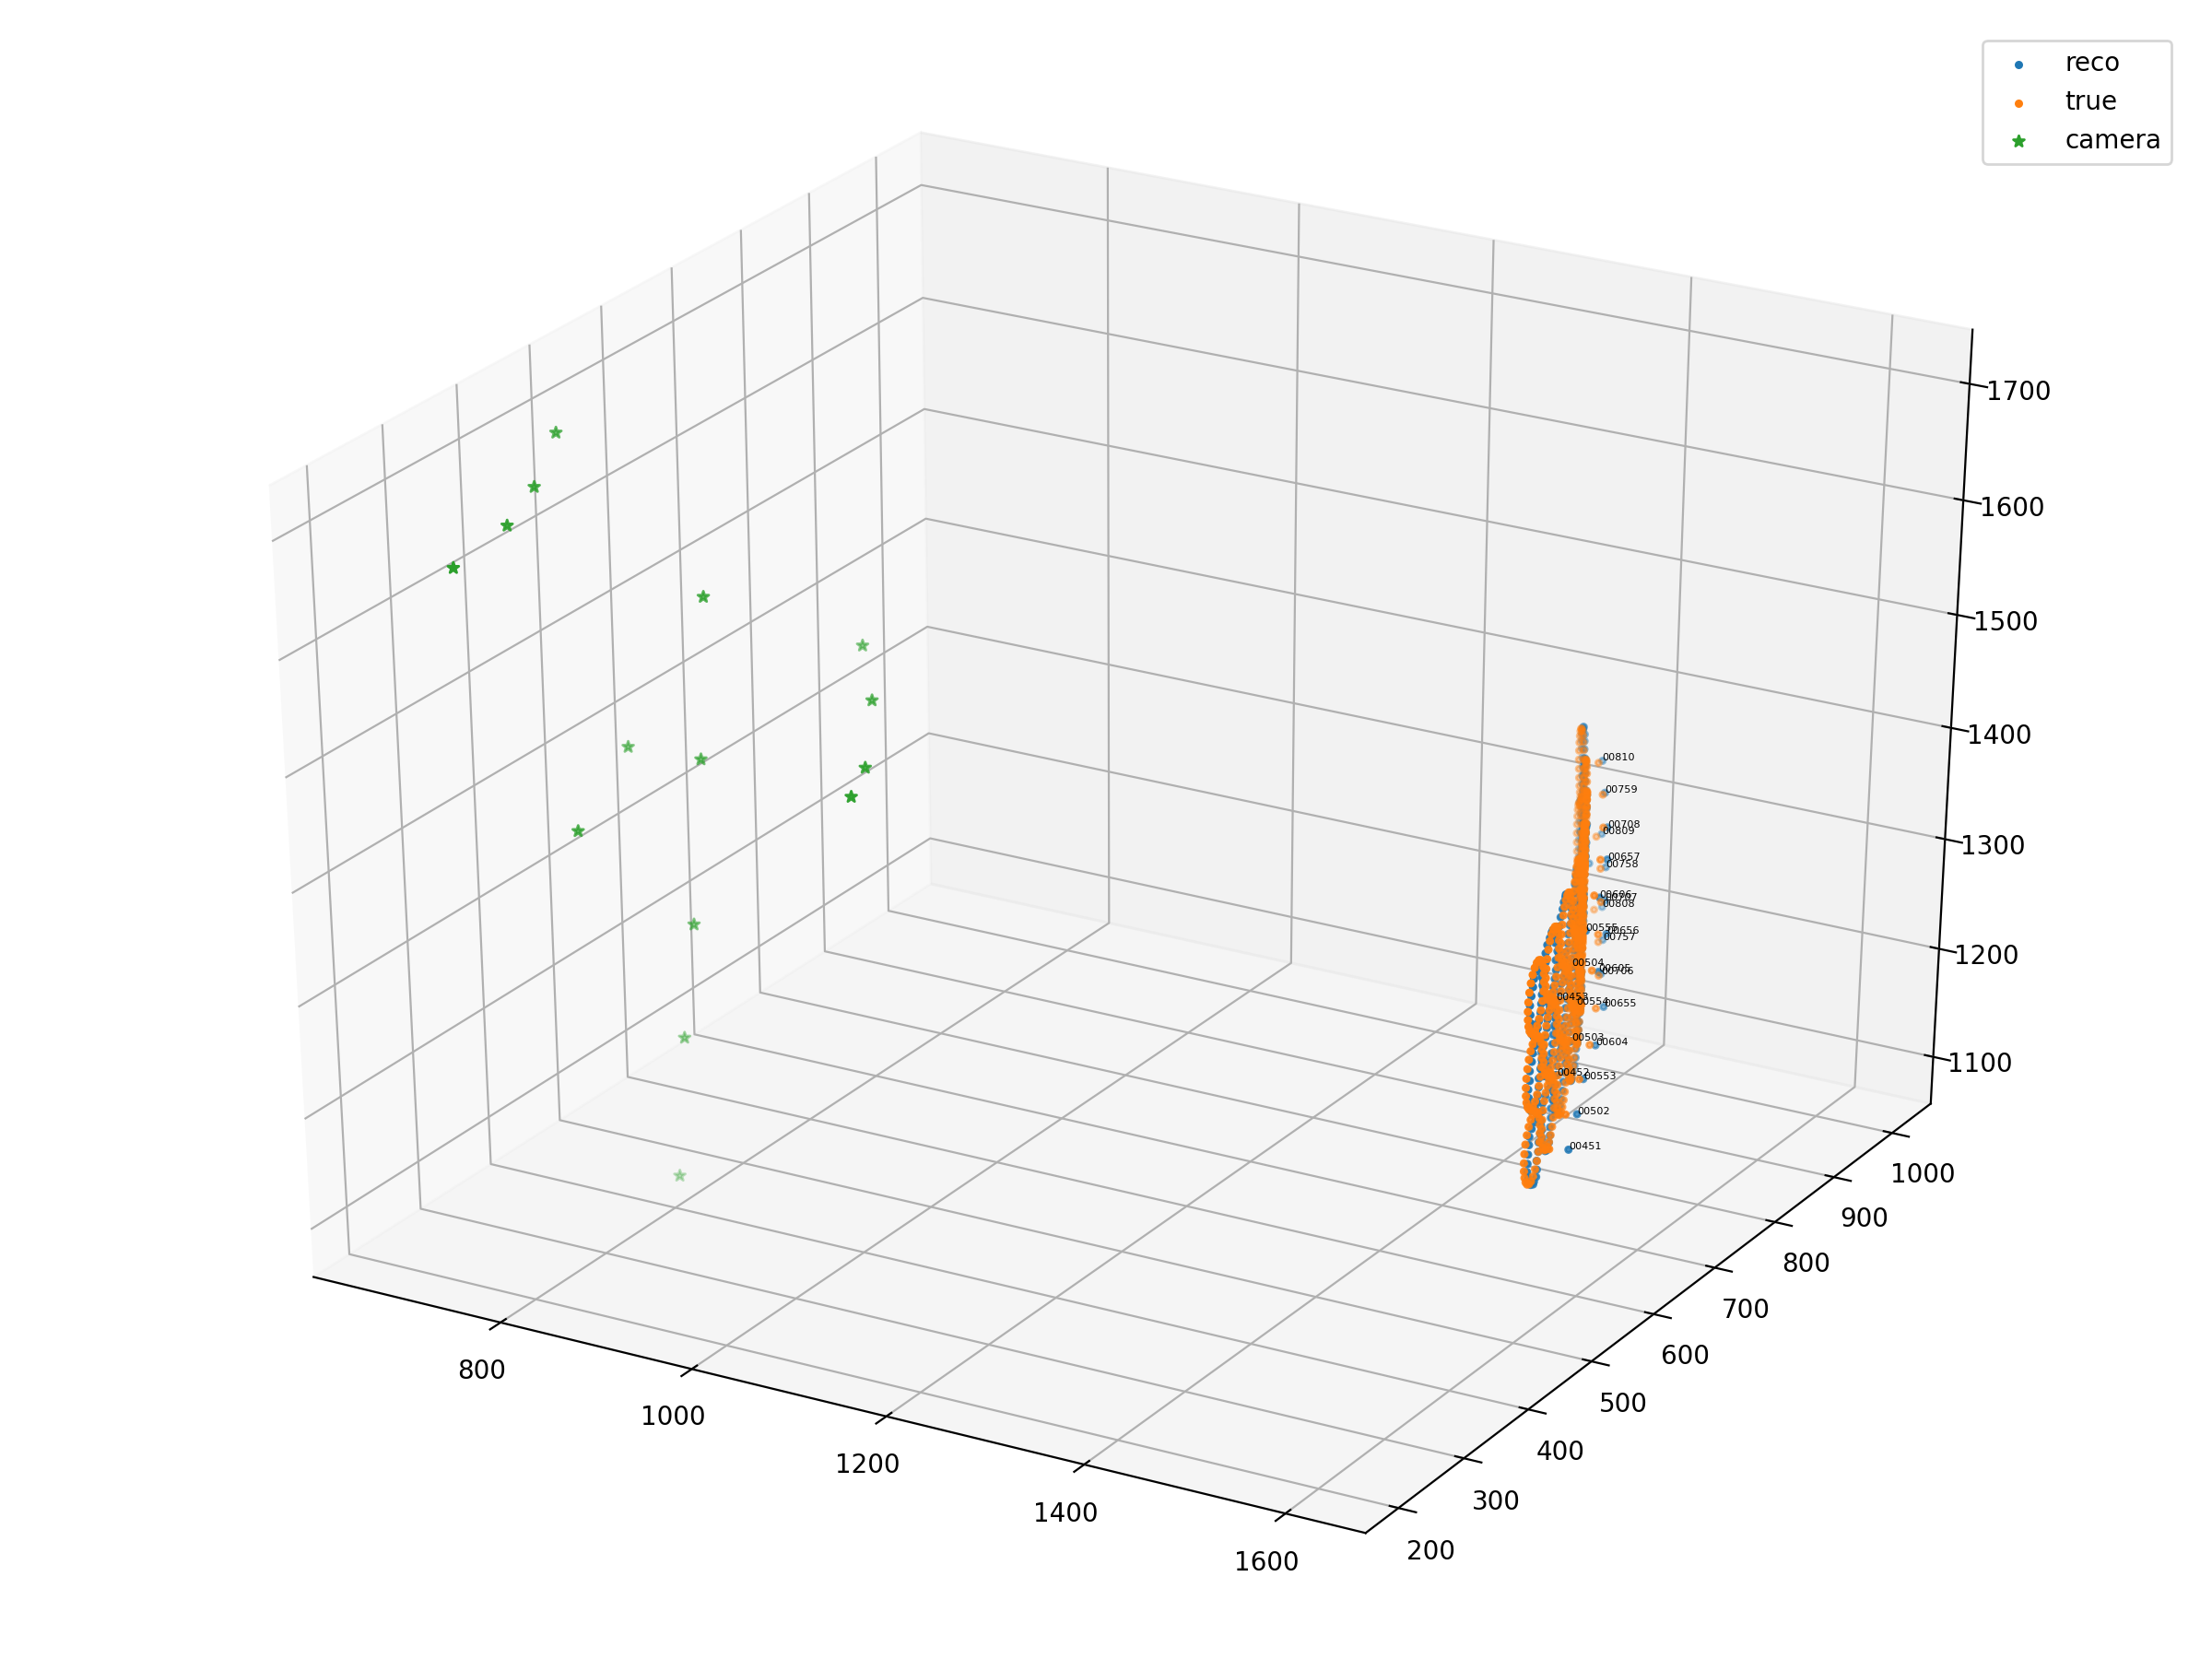

In [45]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reco_transformed[:,0], reco_transformed[:,1], reco_transformed[:,2], marker='.', label="reco", zorder=3)
ax.scatter(true_array[:,0], true_array[:,1], true_array[:,2], marker='.', label="true", zorder=2)
for i, f in enumerate(pmt_locations.keys()):
    ax.text(reco_transformed[i,0], reco_transformed[i,1], reco_transformed[i,2], f[:5], size=4, zorder=4, color='k') 
ax.scatter(camera_positions[:,0], camera_positions[:,1], camera_positions[:,2], marker='*', label="camera", zorder=1)
plt.legend(loc=0)
fig.tight_layout()

<IPython.core.display.Javascript object>


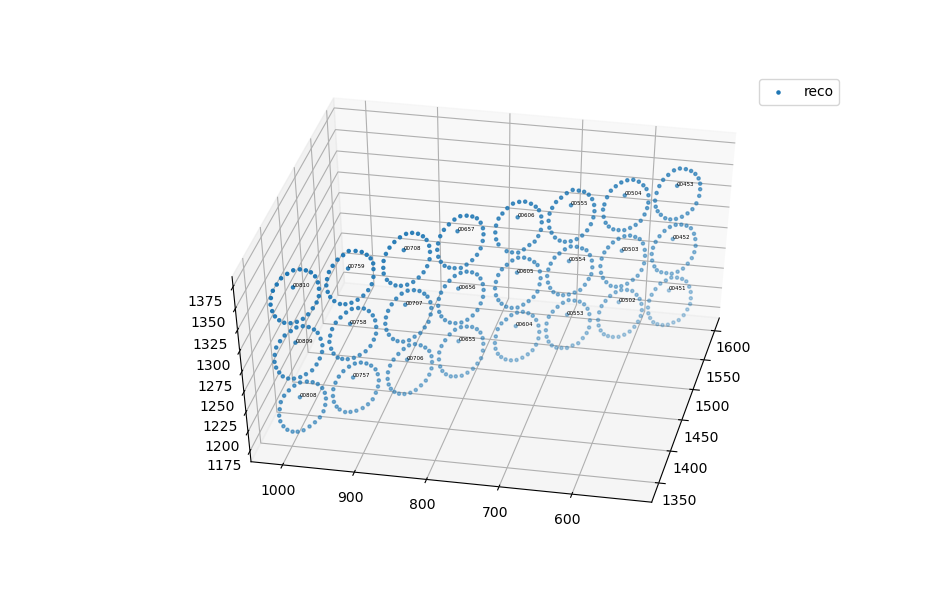

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reco_transformed[:,0], reco_transformed[:,1], reco_transformed[:,2], marker='.', label="reco", zorder=3)
#ax.scatter(true_translated[:,0], true_translated[:,1], true_translated[:,2], marker='.', label="true", zorder=2)
for i, f in enumerate(pmt_locations.keys()):
    ax.text(reco_transformed[i,0], reco_transformed[i,1], reco_transformed[i,2], f[:5], size=4, zorder=4, color='k') 
#ax.scatter(camera_positions[:,0], camera_positions[:,1], camera_positions[:,2], marker='*', label="camera", zorder=1)
plt.legend(loc=0)

<IPython.core.display.Javascript object>


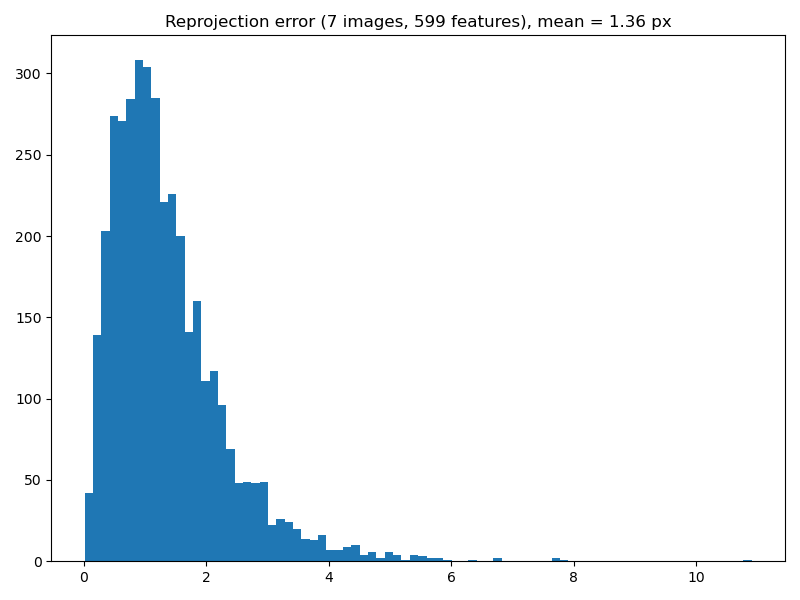

In [50]:
fig, ax = plt.subplots(figsize=(8,6))
reprojection_errors = fitter_all.reprojection_errors(fitter_all.camera_rotations, fitter_all.camera_translations, fitter_all.reco_locations)
reprojection_errors = linalg.norm(reprojection_errors.reshape((-1,2)), axis=1)
ax.hist(reprojection_errors, bins='auto')
ax.set_title("Reprojection error ({} images, {} features), mean = {:.2f} px".format(
    nimages, nfeatures, reprojection_errors.mean()))
fig.tight_layout()

<IPython.core.display.Javascript object>


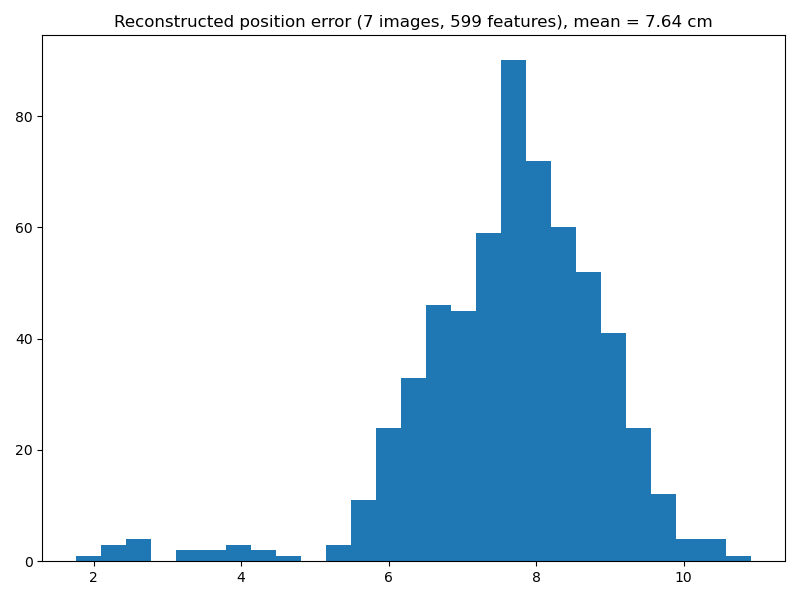

In [28]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(linalg.norm(errors, axis=1), bins='auto')
ax.set_title("Reconstructed position error ({} images, {} features), mean = {:.2f} cm".format(
    nimages, nfeatures, linalg.norm(errors, axis=1).mean()))
fig.tight_layout()

In [32]:
a = np.zeros((3,4))
a[0,[1,2]] = 1
a

array([[0., 1., 1., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [53]:
fitter_all.save_result("SK_demo1_features.txt", "SK_demo1_cameras.txt")

(525, 3)
